# Raw data analisys
In this section we will analice the difference between the molecules label as actives or inactives in the column "Comment".

In [1]:
import pandas as pd
pd.options.display.max_columns = None
!ls

actives.csv    inconclusive.csv       molecule_description.csv
inactives.csv  molecule_activity.csv  raw_data_exploration.ipynb


## Data downloaded from ChEMBL
As the data presented in the contest did not have all columns. Direct download from ChEMBL was carried out searching for "Beta-lactamase AmpC" as the target. The dowloaded file was saved as *molecule_activity*

In [19]:
df = pd.read_csv('./molecule_activity.csv',sep=';')
df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [20]:
# df['Data Validity Comment'].value_counts()

## Split of the data set into 3 cataegaories:
The main idea is to substract from the undifined set, the molecules that are likely actives or inactives not using a arbitrary pChEMBL value cutoff. As I found in some ChEMBL preprocesing pipelines, the column *Comment* is used as a first criteria to split the data, so in this case the comments used were:

* Actives
* Inactives
* Inconclusive

Papers using this aproach:
<div class="csl-entry">Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., Clevert, D. A., &#38; Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <i>Chemical Science</i>, <i>9</i>(24), 5441–5451. https://doi.org/10.1039/C8SC00148K</div>

In [this paper](https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31) the autors did not use the ambiguos results of the HTS study.

* https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31


In [21]:
df.Comment.value_counts().head(10)

Inconclusive               52677
Not Active                  8951
Active                       165
Not Determined                 7
Not applicable                 4
Hydrolysis not detected        2
324165                         1
324147                         1
324209                         1
324191                         1
Name: Comment, dtype: int64

As we can se, the most repeted values are Inconclusive, Not active, and Active ones. The rest of values are goint to be deleted from the data set since they are ambiguos.

First, we are going to analysis the values of the actives and inactives in the same dataframe.

In [22]:
df_inconclusive = df[(df.Comment == 'Inconclusive')]
df_act_inac = df[(df.Comment == 'Active') | (df.Comment == 'Not Active')]

## pChEMBL value in the active and inactive sets
As the value of the pChEMBL was proposed as the main distintion for active molecules and inactives, it would be pertinet to actually check if it is a good idea.

In [23]:
df_count = df_act_inac.groupby(['Standard Type', 'Comment']).count()[['pChEMBL Value', 'Standard Value']]
df_mean = df_act_inac.groupby(['Standard Type', 'Comment']).mean()[['pChEMBL Value', 'Standard Value']]
df_std = df_act_inac.groupby(['Standard Type', 'Comment']).std()[['pChEMBL Value', 'Standard Value']]

### Count grouping by 'Standard Type' and 'Comment'

In [24]:
df_count

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active              0               0
Inhibition    Not Active              0               0
Ki            Active                  8               8
No change     Not Active              0               0
Potency       Active                157             157
              Not Active           8886            8886

Active/Inactive molecules are only present in the Potency Standard value, wich is a general representation of the activity. It would be desiderable build a dataset based only in the ST but only potency is avaliable. There is also active molecules for the Ki ST but are only 8. Those will be considered in the dataset.

### Mean grouping by 'Standard Type' and 'Comment'

In [13]:
df_mean

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           4.895000    13500.000000
No change     Not Active            NaN             NaN
Potency       Active           4.601975    37869.515924
              Not Active       4.978202    37462.626052

This part goes interesting, since the mean value in both datasets have very similar pChEMBL values for the active and inactive molecules, but what is kind of weard is that the mean of inactive molecules ir higger than the mean of active ones. That means that pChEMBL value is not that reliable to distinguish between actives and inactives. To make this more visual, there will be presented the histogram for the pChEMBL value for each dataset.

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df_act = df_act_inac[df_act_inac['Comment'] == 'Active']
df_inact = df_act_inac[df_act_inac['Comment'] == 'Not Active']

df_act_counts = df_act.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_inact_counts = df_inact.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_act_counts.columns = ['pChEMBL Value', 'Relative Count']
df_inact_counts.columns = ['pChEMBL Value', 'Relative Count']

# Standarizing
df_act_counts['Relative Count'] = (df_act_counts['Relative Count'] / df_act_counts['Relative Count'].sum()) * 100
df_inact_counts['Relative Count'] = (df_inact_counts['Relative Count'] / df_inact_counts['Relative Count'].sum()) * 100

#### Actives

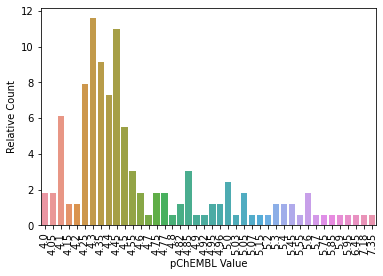

In [9]:
sns.barplot(x = df_act_counts['pChEMBL Value'], y = df_act_counts['Relative Count'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='pChEMBL Value', ylabel='Count'>

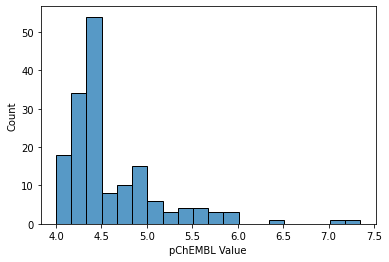

In [10]:
sns.histplot(df_act['pChEMBL Value'], bins=20)

Its important to note that a big quantity of the pChEMBL values for active molecules are low, being almost half of the records between 4.25 and 5.0.

#### Inactives

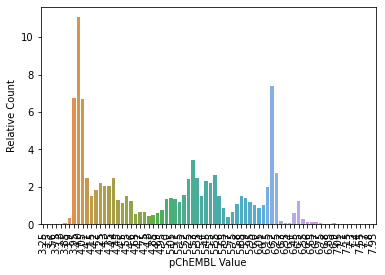

In [11]:
sns.barplot(x = df_inact_counts['pChEMBL Value'], y = df_inact_counts['Relative Count'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='pChEMBL Value', ylabel='Count'>

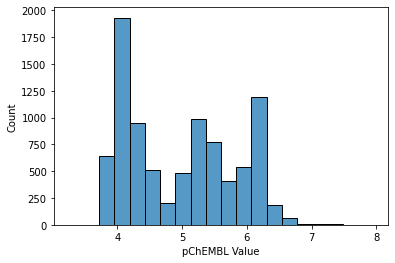

In [12]:
sns.histplot(df_inact['pChEMBL Value'], bins=20)

Also the inactives molevules have many molecules with high pChEMBL value.

#### Inconclusive

<AxesSubplot:xlabel='pChEMBL Value', ylabel='Count'>

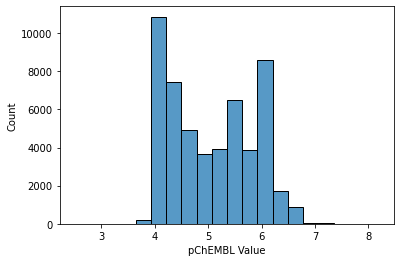

In [13]:
sns.histplot(df_inconclusive['pChEMBL Value'], bins=20)

In the inconclusive values, there is not clear bias in the pChEMBL value, that is ok, since it represent a pool of posible active/inactive values.

As a conclusion, there is not clear difference in pChEMBL value between active and inactive molecules since all distributions looks kind of centered.

### Std grouping by 'Standard Type' and 'Comment'

In [14]:
df_std

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           0.178646     4140.393356
No change     Not Active            NaN             NaN
Potency       Active           0.550129    23917.411609
              Not Active       0.849518    42650.491602

## Saving the dataframes in different csv files

First, we are going to select the columns that are goint to be usefull in the future

In [26]:
columns = ['Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'BAO Label', 'Target Name']
columns_desired_name = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'pChEMBL_Value', 'BAO_Label', 'Target_Name']

df_act = df_act[columns]
df_inact = df_inact[columns]
df_inconclusive = df_inconclusive[columns]

df_act.columns = columns_desired_name
df_inact.columns = columns_desired_name
df_inconclusive.columns = columns_desired_name

Now we save the dataframes in diferent files

In [17]:
df_act.to_csv('./actives.csv', index=False)
df_inact.to_csv('./inactives.csv', index=False)
df_inconclusive.to_csv('./inconclusive.csv', index=False)

## Analyzing some molecule properties between molecules datasets

Part of the code was taken from the book: 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [29]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 


import numpy as np

%matplotlib inline

In [27]:
df_act = df_act[['Smiles', 'pChEMBL_Value']]
df_inact = df_inact[['Smiles', 'pChEMBL_Value']]
df_inconclusive = df_inconclusive[['Smiles', 'pChEMBL_Value']]

In [32]:
def molFromSmiles(smiles):
    if isinstance(smiles, str):
        return Chem.MolFromSmiles(smiles)
    else:
        return False
    
def wtFromMol(mol):
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return 0
    
def MolLogP(mol):
    if mol:
        return Descriptors.MolLogP(mol)
    else:
        return 0
    
def GetFormalCharge(mol):
    if mol:
        return rdmolops.GetFormalCharge(mol)
    else:
        return 0

def add_property_columns_to_df(df_in):
    df_in['MW'] = [wtFromMol(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["logP"] = [MolLogP(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["charge"] = [GetFormalCharge(molFromSmiles(smiles)) for smiles in df_in.Smiles]


In [33]:
add_property_columns_to_df(df_act)
add_property_columns_to_df(df_inact)
add_property_columns_to_df(df_inconclusive)

In [36]:
df_act = df_act.assign(status='Active')
df_inact = df_inact.assign(status='Inactive')

df_act_inac = pd.concat([df_act, df_inact]).sample(frac=1).sample(frac=1).sample(frac=1)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='MW'>

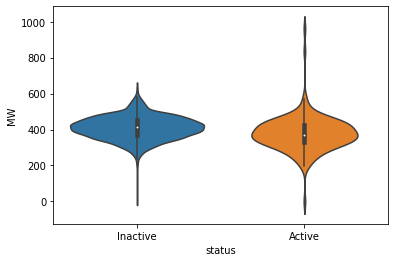

In [37]:
sns.violinplot(df_act_inac["status"],df_act_inac["MW"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='logP'>

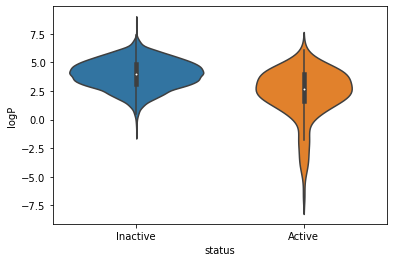

In [38]:
sns.violinplot(df_act_inac["status"],df_act_inac["logP"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='charge'>

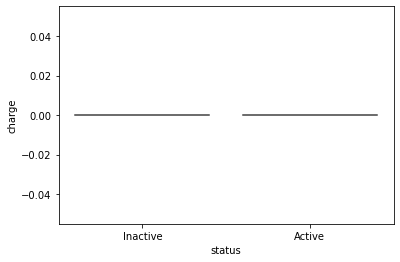

In [39]:
sns.violinplot(df_act_inac["status"],df_act_inac["charge"])

Molecule properties will be revised again at the end of the preprocess